# Part C

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Documents/fin_econometrics_2/project1`


In [2]:
Pkg.instantiate()

Status `~/Documents/fin_econometrics_2/project1/Project.toml`
  [6d3278bc] ARCHModels v2.3.4
  [fbb218c0] BSON v0.3.7
  [ad839575] Blink v0.12.8
  [336ed68f] CSV v0.10.11
  [a93c6f00] DataFrames v1.6.1
⌃ [1313f7d8] DataFramesMeta v0.14.0
⌃ [31c24e10] Distributions v0.25.102
  [587475ba] Flux v0.14.6
⌃ [38e38edf] GLM v1.8.3
  [c601a237] Interact v0.10.5
  [945b72a4] MarketData v0.13.12
  [429524aa] Optim v1.7.8
  [91a5bcdd] Plots v1.39.0
  [ce6b1742] RDatasets v0.7.7
  [b0e4dd01] RollingFunctions v0.8.0
⌅ [2913bbd2] StatsBase v0.33.21
  [f3b207a7] StatsPlots v0.15.6
  [bd369af6] Tables v1.11.1
  [9e3dc215] TimeSeries v0.23.2
  [e88e6eb3] Zygote v0.6.67
  [37e2e46d] LinearAlgebra
  [10745b16] Statistics v1.9.0
Info Packages marked with ⌃ and ⌅ have new versions available, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated`


In [3]:
include("project_functions.jl")

trainW4 (generic function with 1 method)

In [5]:
using Statistics, DataFrames, StatsPlots, TimeSeries, KernelDensity, RollingFunctions, DataFramesMeta, MarketData, Dates

## Data Preperation

In [197]:
using CSV

file_path = "/Users/sander/Documents/fin_econometrics_2/project1/aiz.csv"
aiz = CSV.File(file_path) |> DataFrame
first(aiz, 5)


5×6 DataFrame
 Row │ ret          RV         RV_p        RV_n        RS         RK      
     │ Float64      Float64    Float64     Float64     Float64    Float64 
─────┼────────────────────────────────────────────────────────────────────
   1 │  0.0120472   0.0155114  0.0125216   0.00915502   0.57316   5.09966
   2 │  0.0282087   0.0129384  0.00848344  0.00976895  -0.543282  4.25041
   3 │ -0.00291665  0.0122711  0.00972261  0.00748671   0.646612  4.3631
   4 │  0.014812    0.014421   0.011768    0.00833546   1.49139   9.69829
   5 │  0.00668774  0.0148423  0.0105351   0.0104548    0.140297  4.17256

#### HAR

Let us first consider the HAR model:
$$ RV_t = \beta_0 + \beta_1  RV_{d,t} + \beta_2  RV_{w,t} + \beta_3  RV_{m,t} + \epsilon_t $$


Hence, we will first calculate daily, weekly and monthly Realized Volatilities:

In [156]:
HAR_regressors(aiz.RV)

1478×3 Matrix{Float64}:
 0.0284341  0.0192536  0.0164559
 0.0233918  0.0204309  0.0168141
 0.0151452  0.020227   0.0169144
 0.0213311  0.0215239  0.0173262
 0.0127283  0.0202061  0.0172492
 0.0124503  0.0170093  0.0171405
 0.0149912  0.0153292  0.0169215
 0.0137577  0.0150517  0.0168273
 0.0109854  0.0129826  0.0167815
 0.0108441  0.0126057  0.0166526
 ⋮                     
 0.0171724  0.0160915  0.0137838
 0.0139953  0.0150507  0.0139307
 0.0135318  0.0149018  0.0137996
 0.0153137  0.0149716  0.0137946
 0.0188697  0.0157766  0.0140838
 0.0149667  0.0153354  0.0141763
 0.0148998  0.0155163  0.0141869
 0.0181397  0.0164379  0.0140802
 0.0147966  0.0163345  0.0140325

We can now identify the predictors and target for our study.

In [157]:
predictors = HAR_regressors(aiz.RV)
target = aiz.RV[23:end]
size(predictors), size(target)

((1478, 3), (1478,))

In [158]:
using Flux

In [159]:
xtrain = predictors[1:1000,:] |> permutedims .|> Float32
ytrain = target[1:1000] |> permutedims .|> Float32
xvalid = predictors[1001:1478,:] |> permutedims .|> Float32
yvalid = target[1001:1478] |> permutedims .|> Float32;

Note for self, the above transposes the matrices and converts the elements to 32-bit floating-point numbers.  

We now further standardize the data using ZScoreTransform.

In [160]:
using StatsBase

standardization of data:

In [161]:
fit_xt = StatsBase.fit(ZScoreTransform, log.(xtrain); dims=2, center=true, scale=true)
fit_xv = StatsBase.fit(ZScoreTransform, log.(xvalid); dims=2, center=true, scale=true)
fit_yt = StatsBase.fit(ZScoreTransform, log.(ytrain); dims=2, center=true, scale=true)
fit_yv = StatsBase.fit(ZScoreTransform, log.(yvalid); dims=2, center=true, scale=true)

ZScoreTransform{Float32, Vector{Float32}}(1, 2, Float32[-4.644698], Float32[0.33060977])

ZScoreTransform is a standardization method used to transform data into a standard normal distribution with a mean of 0 and a standard deviation of 1.

In [162]:
xt_std = StatsBase.transform(fit_xt, log.(xtrain))
xv_std = StatsBase.transform(fit_xv, log.(xvalid))
yt_std = StatsBase.transform(fit_yt, log.(ytrain))
yv_std = StatsBase.transform(fit_yv, log.(yvalid))

1×478 Matrix{Float32}:
 -0.943947  0.145748  0.869967  …  1.3257  1.92083  1.30468  0.671599

## FFNN

Now we implement the ffnn model specified in our project_functions.jl file. Note that this is the trainW3() function from the seminar with a few tweeks and changes:
- Usage of batch normalization, 
- Addition of verbose=30, maxpatience=20, drop=0.1f0, lambdaW=0.0001f0 similar to the trained model from seminar 4,
- an additional layer represented by the nodes
- different values for minimizing MSE

In [163]:
FFNN, losses11, losses12 = ffnn(xt_std, yt_std, xv_std, yv_std; nodes=[100, 50, 30], eta=0.001,
n_epochs=500, verbose=30, maxpatience=20, drop=0.1f0, lambdaW=0.0001f0);

Epoch 30 	 Loss: 0.7892529 	 Test: 0.8927834
Epoch 60 	 Loss: 

0.62061477 	 Test: 0.8204454


Stopping early. No improvement in validation loss for 20 epochs.


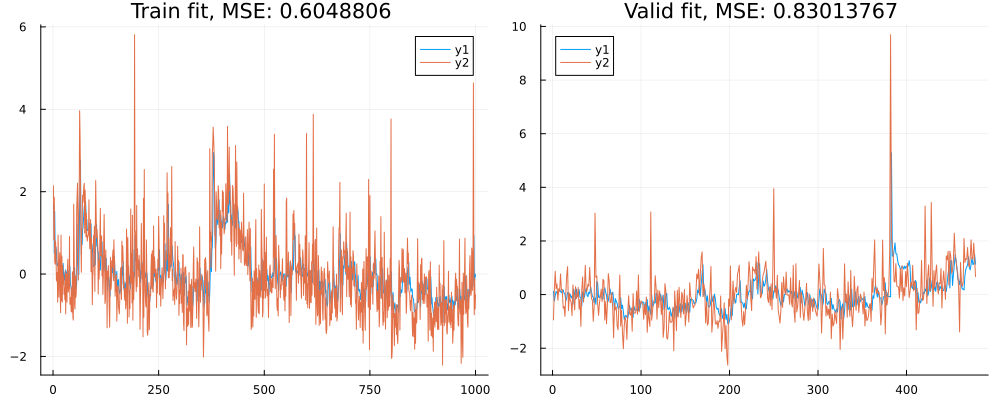

In [164]:
p1 = plot(FFNN(xt_std)', title="Train fit, MSE: $(Flux.Losses.mse(FFNN(xt_std),yt_std)) ",)
p1 = plot!(yt_std')
#
p2 = plot(FFNN(xv_std)', title="Valid fit, MSE: $(Flux.Losses.mse(FFNN(xv_std),yv_std)) ",)
p2 = plot!(yv_std');
plot(p1, p2, size=(1000, 400))

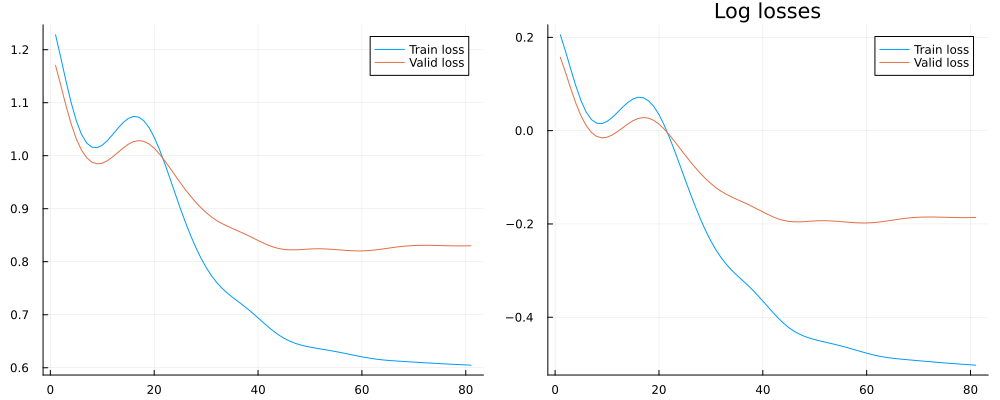

In [165]:
p11 = plot([losses11 losses12], labels=["Train loss" "Valid loss"])
p12 = plot(log.([losses11 losses12]), labels=["Train loss" "Valid loss"], title="Log losses") # might help at some cases
plot(p11, p12, size=(1000,400))

The output provided is from a one-sample Anderson-Darling test, which is used to assess whether a sample comes from a specified distribution. The test strongly rejects the null hypothesis, indicating that the sample does not come from the normal distribution.

In [166]:
using Distributions

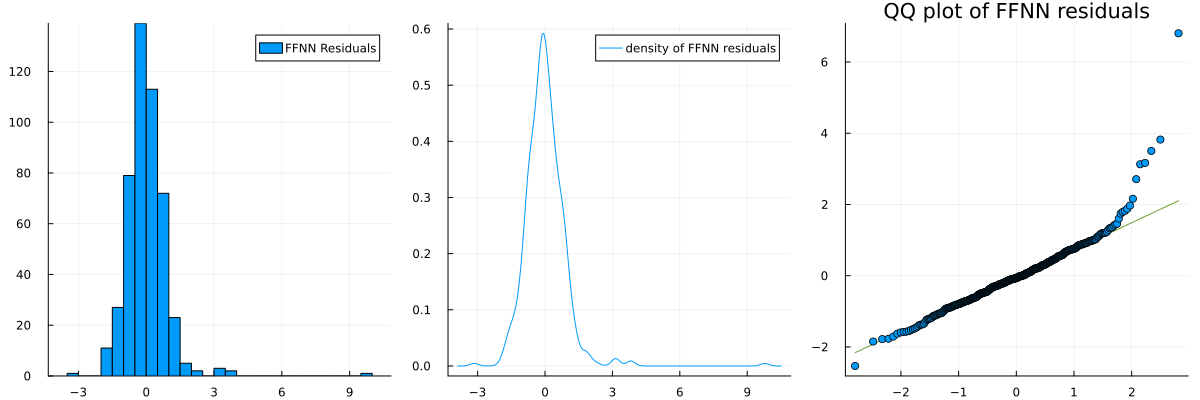

In [167]:
FFNN_resid = yv_std - FFNN(xv_std)
FFNN_quantiles = quantile(Normal(), LinRange(0, 1, length(FFNN_resid)))

qq1 = histogram(FFNN_resid', label = "FFNN Residuals")
qq2 = density(FFNN_resid', label="density of FFNN residuals")
qq3 = qqnorm(vec(FFNN_resid), qqline = :R, title = "QQ plot of FFNN residuals")
plot(qq1, qq2, qq3, layout=(1, 3), size=(1200, 400))

## RNN

In [168]:
xt_rnn = reshape(xt_std, 3, 1, :)
yt_rnn = reshape(yt_std, 1, 1, :)
xv_rnn = reshape(xv_std, 3, 1, :)
yv_rnn = reshape(yv_std, 1, 1, :);

Each "slice" along the third axis represents a sequence of length 3 for x and 1 for y, and the second dimension is used for processing elements within the sequence independently. This reshaping is often used in RNNs where the input is organized as sequences of data, and the network processes each sequence element iteratively. 

In [169]:
size(xt_std), size(yt_std)

((3, 1000), (1, 1000))

In [170]:
size(xt_rnn), size(yt_rnn)

((3, 1, 1000), (1, 1, 1000))

We now see the transformed 3D shape. 

In [171]:
mo1, mb1, lt1, lv1 = trainW4(xt_rnn, yt_rnn, xv_rnn, yv_rnn; nodes=[100, 50, 30], eta=0.001,
n_epochs=500, verbose=30, maxpatience=20, drop=0.1f0, lambdaW=0.0001f0);

Epoch [1/500] 	 Training Loss 0.73 	 Validation Loss 0.83


  ⊚ Counted +1 in patience, 1/20 	 Epoch: 7


  ⊚ Counted +1 in patience, 2/20 	 Epoch: 8


Epoch [31/500] 	 Training Loss 0.65 	 Validation Loss 0.76


  ⊚ Counted +1 in patience, 3/20 	 Epoch: 34


  ⊚ Counted +1 in patience, 4/20 	 Epoch: 35
  ⊚ Counted +1 in patience, 5/20 	 Epoch: 36


  ⊚ Counted +1 in patience, 6/20 	 Epoch: 40
  ⊚ Counted +1 in patience, 7/20 	 Epoch: 41


  ⊚ Counted +1 in patience, 8/20 	 Epoch: 42
  ⊚ Counted +1 in patience, 9/20 	 Epoch: 43


  ⊚ Counted +1 in patience, 10/20 	 Epoch: 44


  ⊚ Counted +1 in patience, 11/20 	 Epoch: 45


  ⊚ Counted +1 in patience, 12/20 	 Epoch: 46


  ⊚ Counted +1 in patience, 13/20 	 Epoch: 47


  ⊚ Counted +1 in patience, 14/20 	 Epoch: 48


  ⊚ Counted +1 in patience, 15/20 	 Epoch: 49
  ⊚ Counted +1 in patience, 16/20 	 Epoch: 50


  ⊚ Counted +1 in patience, 17/20 	 Epoch: 51


  ⊚ Counted +1 in patience, 18/20 	 Epoch: 52
  ⊚ Counted +1 in patience, 19/20 	 Epoch: 53


  ⊚ Counted +1 in patience, 20/20 	 Epoch: 54
 □ Epoch 54 	 Patience is LOST :) 


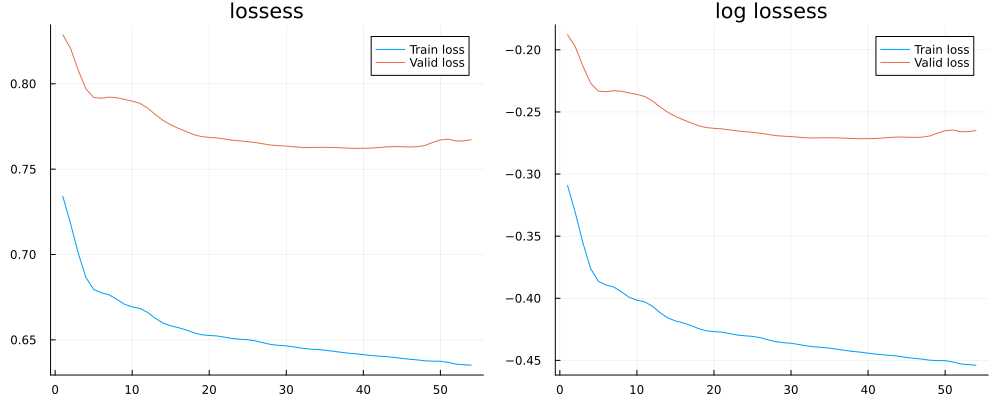

In [172]:
p3l = plot([lt1 lv1], labels=["Train loss" "Valid loss"], title = "lossess")
p4l = plot(log.([lt1 lv1]), labels=["Train loss" "Valid loss"], title = "log lossess")
plot(p3l, p4l, size=(1000,400))

In [173]:
Flux.reset!(mo1) # reset hidden
mo1(xt_rnn) # warm-up model
yhat_mo1_valid = mo1(xv_rnn) |> vec;

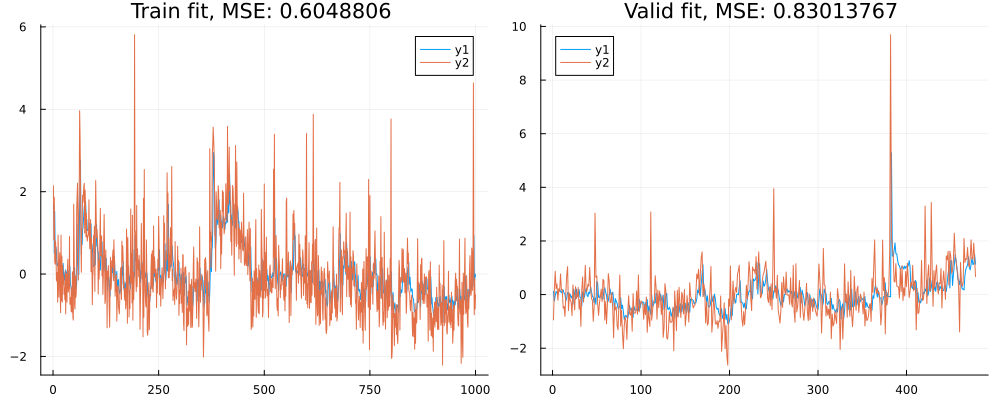

In [174]:
p1 = plot(FFNN(xt_std)', title="Train fit, MSE: $(Flux.Losses.mse(FFNN(xt_std),yt_std)) ",)
p1 = plot!(yt_std')
#
p2 = plot(FFNN(xv_std)', title="Valid fit, MSE: $(Flux.Losses.mse(FFNN(xv_std),yv_std)) ",)
p2 = plot!(yv_std');
plot(p1, p2, size=(1000, 400))

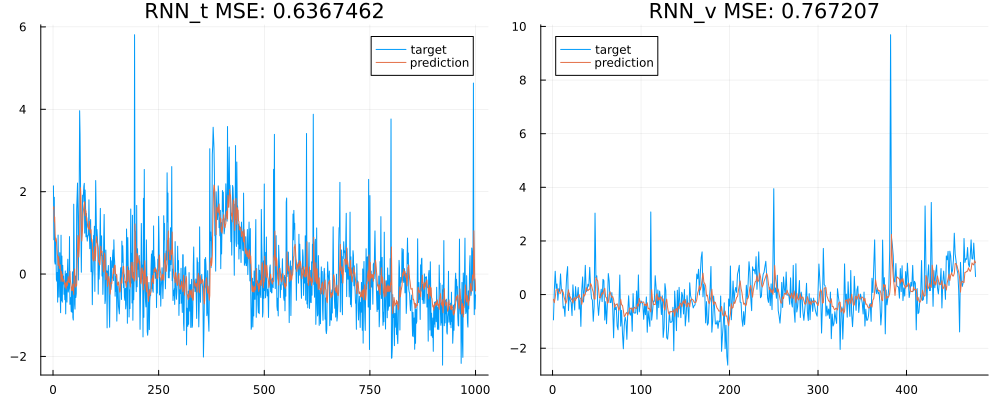

In [175]:
t_fit = mo1(xt_rnn)
plt_tld = plot(yt_rnn |> vec; label="target")
plt_tld = plot!(t_fit |> vec; label="prediction", title="RNN_t MSE: $(Flux.mse(t_fit, yt_rnn))", size = (1000,400))
pred_fit = mo1(xv_rnn)
plt_vld = plot(yv_rnn |> vec; label="target")
plt_vld = plot!(pred_fit |> vec; label="prediction", title="RNN_v MSE: $(Flux.mse(pred_fit, yv_rnn))", size = (1000,400))
plot(plt_tld,plt_vld, size = (1000,400))

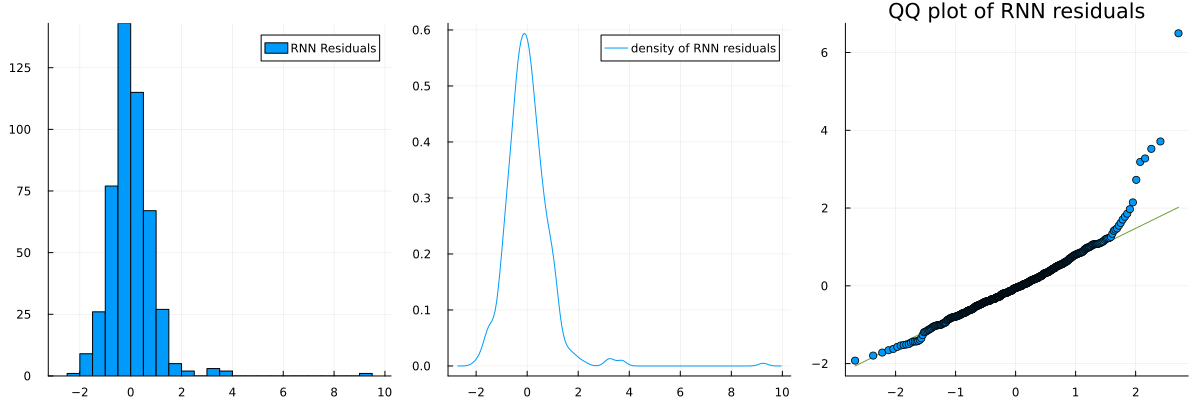

In [176]:
RNN_resid = yv_rnn .- reshape(yhat_mo1_valid, size(yv_rnn))
RNN_resid = dropdims(RNN_resid, dims=(1, 2))

qq1 = histogram(RNN_resid, label = "RNN Residuals")
qq2 = density(RNN_resid, label="density of RNN residuals")
qq3 = qqnorm(RNN_resid, qqline = :R, title = "QQ plot of RNN residuals")

plot(qq1, qq2, qq3, layout=(1, 3), size=(1200, 400))

---

## OLS

In [177]:
beta_har = OLSestimatorconst(yt_std', xt_std')

4×1 Matrix{Float64}:
 -3.882047456706694e-6
  0.2248106998945492
  0.20034621642730782
  0.2262657316061861

In [178]:
yhat_beta = [ones(size(xv_std',1)) xv_std'] * beta_har;

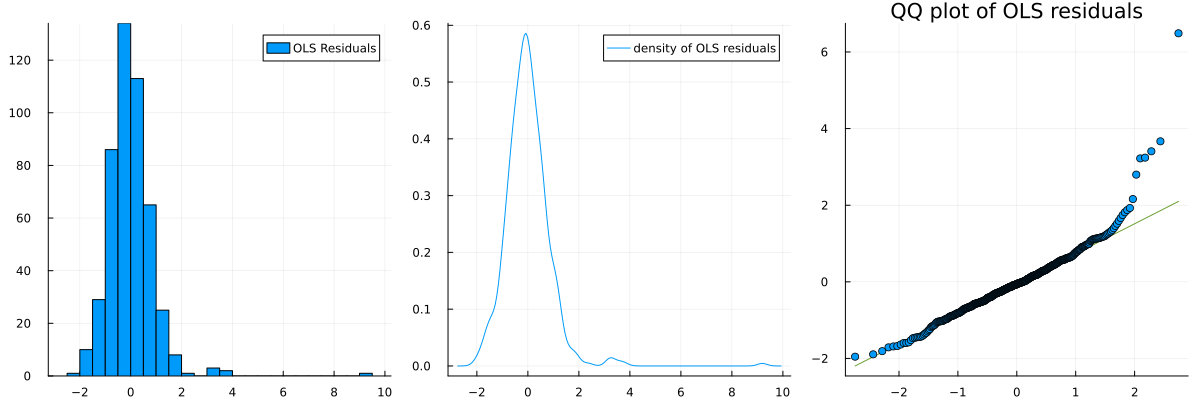

In [179]:
OLS_resid = yv_std' .- yhat_beta

qq1 = histogram(OLS_resid, label = "OLS Residuals")
qq2 = density(OLS_resid, label="density of OLS residuals")
qq3 = qqnorm(vec(OLS_resid), qqline = :R, title = "QQ plot of OLS residuals")

plot(qq1, qq2, qq3, layout=(1, 3), size=(1200, 400))

---

## Comparison

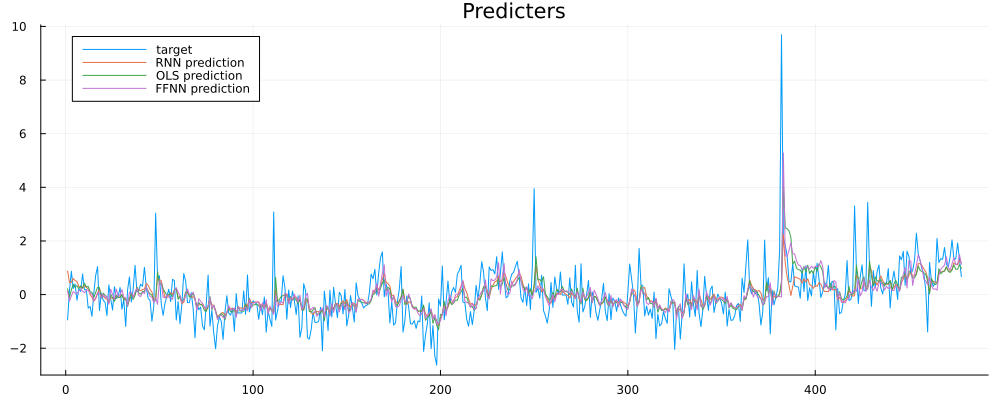

In [180]:
pred_fit = mo1(xv_rnn)
plt_vld = plot(yv_rnn |> vec; label="target")
plt_vld = plot!(pred_fit |> vec; label="RNN prediction", title="Predicters")
plt_vld = plot!(yhat_beta; label="OLS prediction", size = (1000,400))
plt_vld = plot!(FFNN(xv_std)'; label = "FFNN prediction")

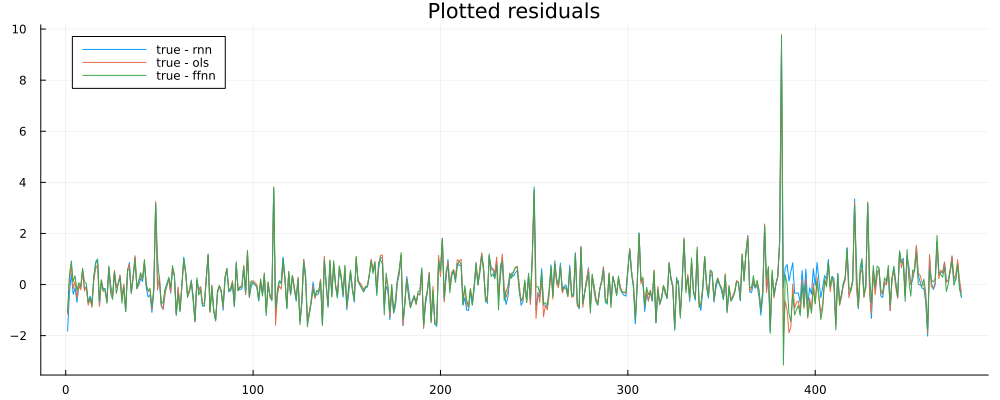

In [181]:
plot(yv_rnn[:] .- pred_fit[:], label="true - rnn")
plot!(yv_rnn[:]  .- yhat_beta, label="true - ols")
plot!(yv_rnn[:] .- FFNN(xv_std)[:], label="true - ffnn", size = (1000, 400), title = "Plotted residuals")


In [182]:
FFNN_MSE_t = Flux.Losses.mse(FFNN(xt_std),yt_std)
FFNN_MSE_v = Flux.Losses.mse(FFNN(xv_std),yv_std)
RNN_MSE_t = Flux.mse(mo1(xt_rnn), yt_rnn)
RNN_MSE_v = Flux.mse(mo1(xv_rnn), yv_rnn)
y_beta = [ones(size(xt_std',1)) xt_std'] * beta_har;
OLS_MSE_t = Flux.mse(y_beta, yt_std')
OLS_MSE_v = Flux.mse(yhat_beta, yv_std')

0.7960174701819276

In [183]:
analysis = DataFrame(
    Model = ["OLS", "FFNN", "RNN"],
    MSE_t = [OLS_MSE_t, FFNN_MSE_t, RNN_MSE_t],
    MSE_v = [OLS_MSE_v, FFNN_MSE_v, RNN_MSE_v]
)

# Display the DataFrame
display(analysis)

3×3 DataFrame
 Row │ Model   MSE_t     MSE_v    
     │ String  Float64   Float64  
─────┼────────────────────────────
   1 │ OLS     0.661535  0.796017
   2 │ FFNN    0.604881  0.830138
   3 │ RNN     0.636746  0.767207

---

## Ensemble

In [184]:
n_ensembles = 5
arr_models = []
ens_loss_t = []
ens_loss_v = []
for iens in 1:n_ensembles
    println("> Running ensemble $iens")
    @time mo0, mb0, lt0, lv0 = trainW4(xt_rnn, yt_rnn, xv_rnn, yv_rnn; nodes=[100, 50, 30], eta=0.001,
    n_epochs=500, verbose=30, maxpatience=20, drop=0.1f0, lambdaW=0.0001f0)
    # _ saving
    push!(arr_models, mb0) # saving the best model for each ensemble
    push!(ens_loss_t, lt0)
    push!(ens_loss_v, lv0)
end

> Running ensemble 1


Epoch [1/500] 	 Training Loss 0.79 	 Validation Loss 0.88


  ⊚ Counted +1 in patience, 1/20 	 Epoch: 3
  ⊚ Counted +1 in patience, 2/20 	 Epoch: 4


  ⊚ Counted +1 in patience, 3/20 	 Epoch: 5


  ⊚ Counted +1 in patience, 4/20 	 Epoch: 9
  ⊚ Counted +1 in patience, 5/20 	 Epoch: 10


  ⊚ Counted +1 in patience, 6/20 	 Epoch: 11
  ⊚ Counted +1 in patience, 7/20 	 Epoch: 12


Epoch [31/500] 	 Training Loss 0.66 	 Validation Loss 0.79


  ⊚ Counted +1 in patience, 8/20 	 Epoch: 58
  ⊚ Counted +1 in patience, 9/20 	 Epoch: 59


Epoch [61/500] 	 Training Loss 0.64 	 Validation Loss 0.77


  ⊚ Counted +1 in patience, 10/20 	 Epoch: 66
  ⊚ Counted +1 in patience, 11/20 	 Epoch: 67


  ⊚ Counted +1 in patience, 12/20 	 Epoch: 68
  ⊚ Counted +1 in patience, 13/20 	 Epoch: 69


  ⊚ Counted +1 in patience, 14/20 	 Epoch: 70
  ⊚ Counted +1 in patience, 15/20 	 Epoch: 71


  ⊚ Counted +1 in patience, 16/20 	 Epoch: 72
  ⊚ Counted +1 in patience, 17/20 	 Epoch: 73


  ⊚ Counted +1 in patience, 18/20 	 Epoch: 74


  ⊚ Counted +1 in patience, 19/20 	 Epoch: 75
  ⊚ Counted +1 in patience, 20/20 	 Epoch: 76
 □ Epoch 76 	 Patience is LOST :) 
  7.217761 seconds (10.51 M allocations: 27.124 GiB, 12.51% gc time)
> Running ensemble 2


Epoch [1/500] 	 Training Loss 0.94 	 Validation Loss 0.97


  ⊚ Counted +1 in patience, 1/20 	 Epoch: 4


  ⊚ Counted +1 in patience, 2/20 	 Epoch: 5


  ⊚ Counted +1 in patience, 3/20 	 Epoch: 6
  ⊚ Counted +1 in patience, 4/20 	 Epoch: 7


  ⊚ Counted +1 in patience, 5/20 	 Epoch: 14


  ⊚ Counted +1 in patience, 6/20 	 Epoch: 15


  ⊚ Counted +1 in patience, 7/20 	 Epoch: 23
  ⊚ Counted +1 in patience, 8/20 	 Epoch: 24


  ⊚ Counted +1 in patience, 9/20 	 Epoch: 25
  ⊚ Counted +1 in patience, 10/20 	 Epoch: 26


Epoch [31/500] 	 Training Loss 0.66 	 Validation Loss 0.79


  ⊚ Counted +1 in patience, 11/20 	 Epoch: 44
  ⊚ Counted +1 in patience, 12/20 	 Epoch: 45


  ⊚ Counted +1 in patience, 13/20 	 Epoch: 46


Epoch [61/500] 	 Training Loss 0.65 	 Validation Loss 0.77


  ⊚ Counted +1 in patience, 14/20 	 Epoch: 86


  ⊚ Counted +1 in patience, 15/20 	 Epoch: 87
  ⊚ Counted +1 in patience, 16/20 	 Epoch: 88


  ⊚ Counted +1 in patience, 17/20 	 Epoch: 89


  ⊚ Counted +1 in patience, 18/20 	 Epoch: 90
Epoch [91/500] 	 Training Loss 0.64 	 Validation Loss 0.76


  ⊚ Counted +1 in patience, 19/20 	 Epoch: 92
  ⊚ Counted +1 in patience, 20/20 	 Epoch: 93
 □ Epoch 93 	 Patience is LOST :) 
  8.746303 seconds (12.87 M allocations: 33.192 GiB, 11.99% gc time)
> Running ensemble 3


Epoch [1/500] 	 Training Loss 0.73 	 Validation Loss 0.83
  ⊚ Counted +1 in patience, 1/20 	 Epoch: 2


  ⊚ Counted +1 in patience, 2/20 	 Epoch: 3


  ⊚ Counted +1 in patience, 3/20 	 Epoch: 13
  ⊚ Counted +1 in patience, 4/20 	 Epoch: 14


  ⊚ Counted +1 in patience, 5/20 	 Epoch: 15


  ⊚ Counted +1 in patience, 6/20 	 Epoch: 26


  ⊚ Counted +1 in patience, 7/20 	 Epoch: 27
  ⊚ Counted +1 in patience, 8/20 	 Epoch: 28


  ⊚ Counted +1 in patience, 9/20 	 Epoch: 29


Epoch [31/500] 	 Training Loss 0.65 	 Validation Loss 0.77


  ⊚ Counted +1 in patience, 10/20 	 Epoch: 39


  ⊚ Counted +1 in patience, 11/20 	 Epoch: 40
  ⊚ Counted +1 in patience, 12/20 	 Epoch: 41


  ⊚ Counted +1 in patience, 13/20 	 Epoch: 52


  ⊚ Counted +1 in patience, 14/20 	 Epoch: 53


  ⊚ Counted +1 in patience, 15/20 	 Epoch: 54


  ⊚ Counted +1 in patience, 16/20 	 Epoch: 55
  ⊚ Counted +1 in patience, 17/20 	 Epoch: 56


  ⊚ Counted +1 in patience, 18/20 	 Epoch: 57
  ⊚ Counted +1 in patience, 19/20 	 Epoch: 58


  ⊚ Counted +1 in patience, 20/20 	 Epoch: 61
Epoch [61/500] 	 Training Loss 0.64 	 Validation Loss 0.76
 □ Epoch 61 	 Patience is LOST :) 
  5.799057 seconds (8.44 M allocations: 21.770 GiB, 12.61% gc time)
> Running ensemble 4


Epoch [1/500] 	 Training Loss 0.99 	 Validation Loss 1.01


  ⊚ Counted +1 in patience, 1/20 	 Epoch: 4


  ⊚ Counted +1 in patience, 2/20 	 Epoch: 5
  ⊚ Counted +1 in patience, 3/20 	 Epoch: 6


  ⊚ Counted +1 in patience, 4/20 	 Epoch: 7
  ⊚ Counted +1 in patience, 5/20 	 Epoch: 8


  ⊚ Counted +1 in patience, 6/20 	 Epoch: 9


  ⊚ Counted +1 in patience, 7/20 	 Epoch: 13
  ⊚ Counted +1 in patience, 8/20 	 Epoch: 14


  ⊚ Counted +1 in patience, 9/20 	 Epoch: 15


  ⊚ Counted +1 in patience, 10/20 	 Epoch: 16
  ⊚ Counted +1 in patience, 11/20 	 Epoch: 17


  ⊚ Counted +1 in patience, 12/20 	 Epoch: 23


  ⊚ Counted +1 in patience, 13/20 	 Epoch: 24
  ⊚ Counted +1 in patience, 14/20 	 Epoch: 25


  ⊚ Counted +1 in patience, 15/20 	 Epoch: 26


  ⊚ Counted +1 in patience, 16/20 	 Epoch: 27
  ⊚ Counted +1 in patience, 17/20 	 Epoch: 28


Epoch [31/500] 	 Training Loss 0.66 	 Validation Loss 0.79


Epoch [61/500] 	 Training Loss 0.65 	 Validation Loss 0.77


Epoch [91/500] 	 Training Loss 0.64 	 Validation Loss 0.77


  ⊚ Counted +1 in patience, 18/20 	 Epoch: 101
  ⊚ Counted +1 in patience, 19/20 	 Epoch: 102


  ⊚ Counted +1 in patience, 20/20 	 Epoch: 104
 □ Epoch 104 	 Patience is LOST :) 
  9.544327 seconds (14.39 M allocations: 37.119 GiB, 12.63% gc time)
> Running ensemble 5
Epoch [1/500] 	 Training Loss 0.77 	 Validation Loss 0.85


  ⊚ Counted +1 in patience, 1/20 	 Epoch: 3
  ⊚ Counted +1 in patience, 2/20 	 Epoch: 4


  ⊚ Counted +1 in patience, 3/20 	 Epoch: 5


  ⊚ Counted +1 in patience, 4/20 	 Epoch: 9
  ⊚ Counted +1 in patience, 5/20 	 Epoch: 10


  ⊚ Counted +1 in patience, 6/20 	 Epoch: 11


Epoch [31/500] 	 Training Loss 0.65 	 Validation Loss 0.78


  ⊚ Counted +1 in patience, 7/20 	 Epoch: 56
  ⊚ Counted +1 in patience, 8/20 	 Epoch: 57


  ⊚ Counted +1 in patience, 9/20 	 Epoch: 58
  ⊚ Counted +1 in patience, 10/20 	 Epoch: 59


  ⊚ Counted +1 in patience, 11/20 	 Epoch: 60
Epoch [61/500] 	 Training Loss 0.64 	 Validation Loss 0.77


  ⊚ Counted +1 in patience, 12/20 	 Epoch: 63
  ⊚ Counted +1 in patience, 13/20 	 Epoch: 64


  ⊚ Counted +1 in patience, 14/20 	 Epoch: 65
  ⊚ Counted +1 in patience, 15/20 	 Epoch: 66


  ⊚ Counted +1 in patience, 16/20 	 Epoch: 67
  ⊚ Counted +1 in patience, 17/20 	 Epoch: 68


  ⊚ Counted +1 in patience, 18/20 	 Epoch: 69
  ⊚ Counted +1 in patience, 19/20 	 Epoch: 70


  ⊚ Counted +1 in patience, 20/20 	 Epoch: 71
 □ Epoch 71 	 Patience is LOST :) 
  6.414426 seconds (9.82 M allocations: 25.340 GiB, 12.31% gc time)


In [185]:
arr_models

5-element Vector{Any}:
 Chain(Recur(LSTMCell(3 => 100)), Dropout(0.1), Dense(100 => 50), Dropout(0.1), Dense(50 => 1))  # 46_901 parameters, plus 200 non-trainable
 Chain(Recur(LSTMCell(3 => 100)), Dropout(0.1), Dense(100 => 50), Dropout(0.1), Dense(50 => 1))  # 46_901 parameters, plus 200 non-trainable
 Chain(Recur(LSTMCell(3 => 100)), Dropout(0.1), Dense(100 => 50), Dropout(0.1), Dense(50 => 1))  # 46_901 parameters, plus 200 non-trainable
 Chain(Recur(LSTMCell(3 => 100)), Dropout(0.1), Dense(100 => 50), Dropout(0.1), Dense(50 => 1))  # 46_901 parameters, plus 200 non-trainable
 Chain(Recur(LSTMCell(3 => 100)), Dropout(0.1), Dense(100 => 50), Dropout(0.1), Dense(50 => 1))  # 46_901 parameters, plus 200 non-trainable

Plotting coefficients of the first model

In [186]:
m_pars = Flux.params(arr_models[1]) |> collect .|> vec

9-element Vector{Vector{Float32}}:
 [0.009111469, -0.0050567184, 0.099282585, 0.05838669, 0.046645805, -0.12352998, -0.01495077, -0.0006356277, -0.035253633, 0.0424906  …  -0.005748346, 0.024901828, 0.06811791, -0.09766859, -0.028159063, -0.095024325, 0.058225963, 0.0111682825, 0.11879785, 0.07679635]
 [0.037303578, 0.096898824, 0.08724481, -0.013617433, -0.06973973, 0.08331484, -0.030405696, -0.052238833, 0.0645972, 0.06813406  …  -0.034584567, 0.060640547, -0.04037431, 0.035482705, 0.0021204457, 0.08142721, -0.034971606, -0.015607522, -0.0038806438, -0.063603185]
 [0.025495723, -0.015976803, -0.008800703, -0.010956886, -0.012064227, 0.011208404, -0.016900707, -0.00073624175, -0.0066493805, 0.0067204162  …  -0.016293786, -0.017443104, -0.025003664, 0.003406396, -0.009442661, -0.0013768818, 0.0068847705, -0.00888537, -0.029733436, -0.0017341436]
 [0.042142715, -0.057889353, 0.011048697, 0.040229704, 0.052556053, -0.05453566, -0.028140604, 0.05036427, -0.04038351, -0.01938683  …  -0.009

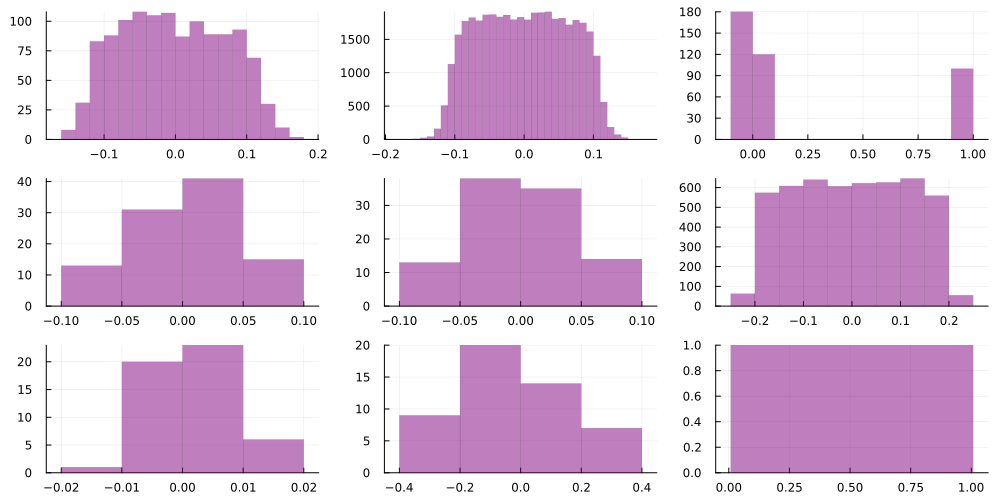

In [187]:
plot(histogram.(m_pars)..., line=(0), fill=(1, 0.5, :purple), legend=:none, size = (1000, 500))

Plot losses of all models in ensemble
Fit all models to see the output (still on validation which we use in training for stopping, for instance, thus not true Out-of-sample):

In [188]:
yhat_array = []
for m in arr_models
    Flux.reset!(m) # reset model
    m(xt_rnn) # warm-up the model for time step prior prediction
    push!(yhat_array, m(xv_rnn))
end

In [189]:
yhat_ensemble = mean(yhat_array) |> vec;

In [190]:
size(xtrain), size(ytrain)

((3, 1000), (1, 1000))

HAR prediction

In [191]:
har_coefs = OLSestimatorconst(yt_std', xt_std')
yhat_har_valid = (xv_std' * har_coefs[2:end]) .+ har_coefs[1];

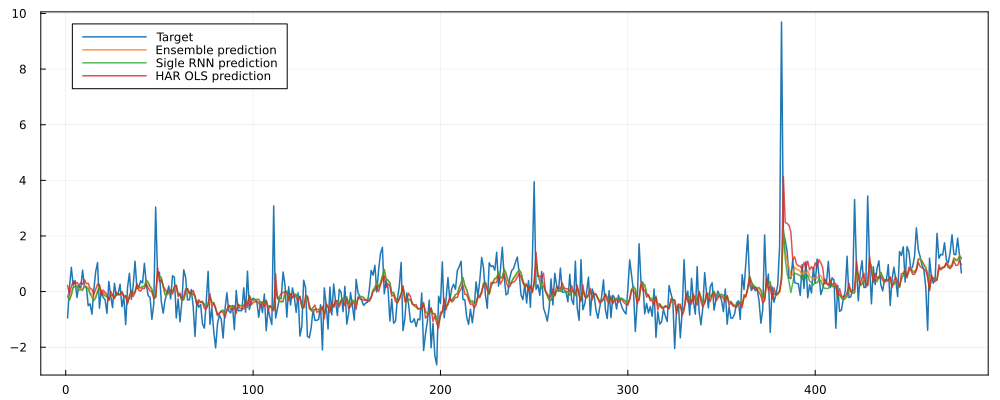

In [192]:
plot(yv_rnn |> vec, label="Target", size=(1000,400), framestyle=:box, line=(1.5, 1.0, :solid), palette=:tab10)
plot!(yhat_ensemble, label="Ensemble prediction", line=(1.5, 0.8, :solid))
plot!(yhat_mo1_valid, label="Sigle RNN prediction", line=(1.5, 0.8, :solid))
plot!(yhat_har_valid, label="HAR OLS prediction", line=(1.5, 0.8, :solid))

In [193]:
println(" OLS: ", Flux.mse(yhat_har_valid, yv_rnn |> vec), "\n",
    " Ens: ", Flux.mse(yhat_ensemble, yv_rnn |> vec), "\n",
    " RNN single:  ", Flux.mse(yhat_mo1_valid, yv_rnn |> vec), "\n")

 OLS: 0.7960174701819276
 Ens: 0.76542395
 RNN single:  0.767207



Let's see the individual predictions:

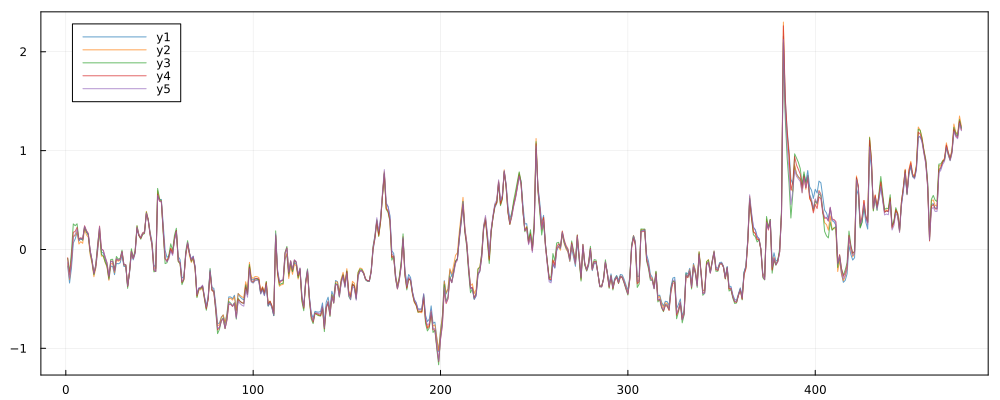

In [194]:
plot(yhat_array .|> vec, framestyle=:box, line=(1, 0.7, :solid), palette=:tab10, size=(1000,400))

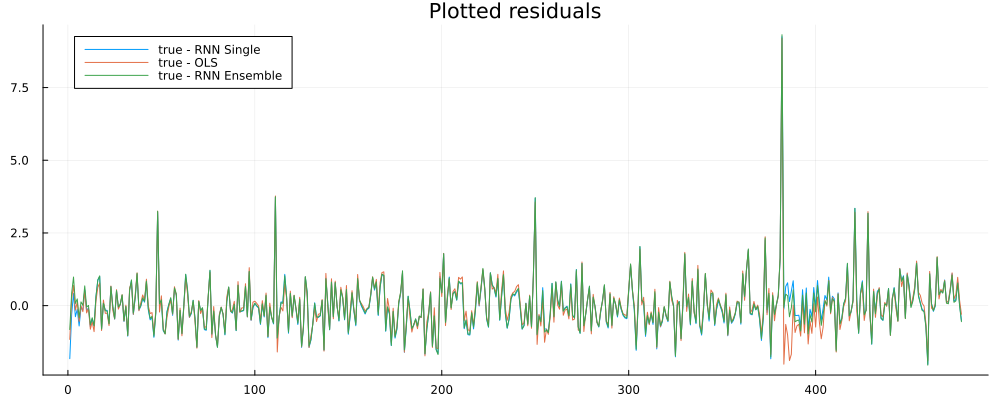

In [195]:
plot(yv_rnn[:] .- pred_fit[:], label="true - RNN Single")
plot!(yv_rnn[:]  .- yhat_har_valid[:], label="true - OLS")
plot!(yv_rnn[:] .- yhat_ensemble[:], label="true - RNN Ensemble", size = (1000, 400), title = "Plotted residuals")

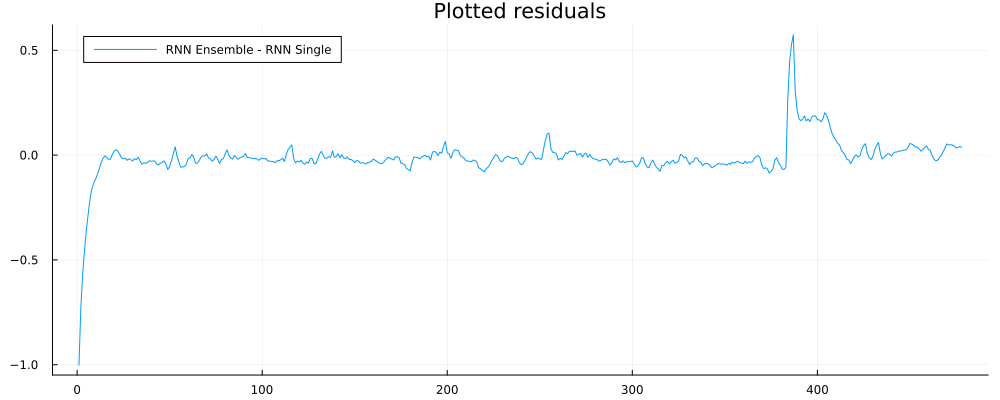

In [196]:
plot(yhat_ensemble[:] .- pred_fit[:], label="RNN Ensemble - RNN Single", size = (1000, 400), title = "Plotted residuals")